In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats
import datetime as dt

In [3]:
calib_year = 2015

In [4]:
case_name = 'hillslope-soiltest-pfttest'

In [5]:
'''Correlation'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def spearman(x, y):
    res = scipy.stats.spearmanr(x, y).statistic
    return res

In [6]:
'''Import Hillslope Model Results'''
file_dir = '/glade/derecho/scratch/marielj/archive/' + case_name + '/lnd/hist/'
files = glob(file_dir + case_name + '.clm2.h2.*.nc')
colfiles = glob(file_dir + case_name + '.clm2.h3.*.nc')

data = xr.open_mfdataset(files)
coldata = xr.open_mfdataset(colfiles)

In [7]:
coldata

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                         time: 7666, column: 3, hist_interval: 2, lndgrid: 1,
                         gridcell: 1, landunit: 1, pft: 12)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) object 2011-01-01 00:00:00 ... 2032-01-01 00:0...
Dimensions without coordinates: column, hist_interval, lndgrid, gridcell,
                                landunit, pft
Data variables: (12/82)
    hillslope_distance  (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_width     (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_area      (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_elev      (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_slope     (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_aspect    (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ...                  ...
    TSA                 (time, pft) float32 dask.array<chunksize=(365, 12), meta=np.ndarray>
    ZWT                 (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ZWT_PERCH           (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(365, 25, 3), meta=np.ndarray>
    H2OSOI              (time, levsoi, column) float32 dask.array<chunksize=(365, 20, 3), meta=np.ndarray>
    SOILICE             (time, levsoi, column) float32 dask.array<chunksize=(365, 20, 3), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/18/24 16:47:33
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     day_1

In [25]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in theA metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out calib year
wte = dt1[dt1.DATE.dt.year == calib_year]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)

# Pull out all data
wte_all = dt1[(dt1.DATE.dt.year > 2011) & (dt1.DATE.dt.year < 2018) ]
wte_all = wte_all[wte_all.PEATLAND == 'S2'].reset_index(drop = True)

In [9]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[dt2.Date.dt.year == calib_year]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

In [26]:
'''Convert WTE to WTD'''
wte['WTD'] = -(422.0 - wte.WTE)
wte_all['WTD'] = -(422.0 - wte_all.WTE)

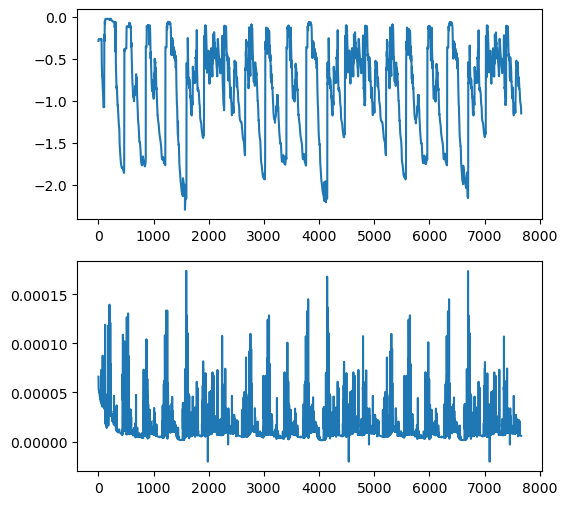

In [11]:
'''General Model Plot'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (6, 6))

#Plot CLM hillslope - column level
ax1.plot(-data.ZWT)

#Plot CLM hillslope - runoff
ax2.plot(data.QRUNOFF)

In [12]:
#Separate out columns
Lagg = coldata.sel(column = 0)
Bog = coldata.sel(column = 1)
Upland = coldata.sel(column = 2)

### Water Table Comparison

In [13]:
meas_wt = wte.WTD
mod_wt = -Bog.ZWT[(coldata.time.dt.year == calib_year)]

In [14]:
rsquared(meas_wt, mod_wt)

0.02227269715130096

In [15]:
nse(mod_wt, meas_wt)

-9.017717455114326

In [16]:
spearman(mod_wt, meas_wt)

0.0023495442098171557

### Streamflow comparison

In [17]:
meas_stream = stream.Flow_mms
mod_stream = data.QRUNOFF[(data.time.dt.year == calib_year)].values.reshape(365)

In [18]:
rsquared(meas_stream, mod_stream)

0.3112959898665896

In [19]:
nse(mod_stream, meas_stream)

-0.9656984049708026

In [20]:
spearman(mod_stream, meas_stream)

0.6227153775580189

## All data comparison

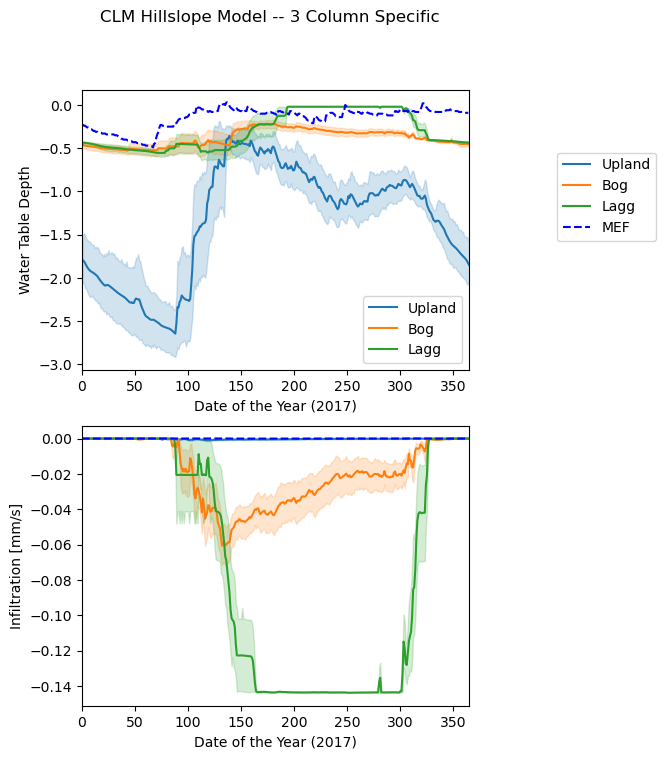

In [21]:
'''Plot model results'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (5, 8))

#Plot CLM hillslope - column level
sns.lineplot(x = Upland.time.dt.dayofyear, y = -Upland.ZWT, label = 'Upland', ax = ax1)
sns.lineplot(x = Bog.time.dt.dayofyear, y = -Bog.ZWT, label = 'Bog', ax = ax1)
sns.lineplot(x = Lagg.time.dt.dayofyear, y = -Lagg.ZWT, label = 'Lagg', ax = ax1)

#Plot Marcell data 
ax1.plot(wte.WTD, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth')
ax1.set_xlim(0, 365)

#Plot CLM hillslope - column level
sns.lineplot(x = Upland.time.dt.dayofyear, y = -Upland.QINFL, label = 'Upland', ax = ax2)
sns.lineplot(x = Bog.time.dt.dayofyear, y = -Bog.QINFL, label = 'Bog', ax = ax2)
sns.lineplot(x = Lagg.time.dt.dayofyear, y = -Lagg.QINFL, label = 'Lagg', ax = ax2)

#Plot Marcell data 
ax2.plot(stream['Flow_mms'], color = 'blue', linestyle='--', label ='MEF')

#Plot spcifics
ax2.set_xlabel('Date of the Year (2017)')
ax2.set_ylabel('Infiltration [mm/s]')
ax2.set_xlim(0, 365)

plt.suptitle('CLM Hillslope Model -- 3 Column Specific')
plt.legend(bbox_to_anchor=(1.5, 2))
plt.show()

(0.0, 365.0)

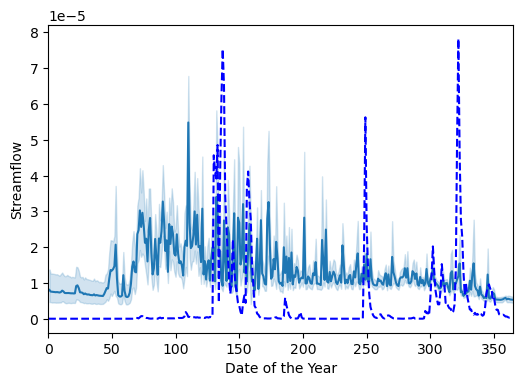

In [48]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 4))

#Plot CLM hillslope - column level
sns.lineplot(x = data.time.dt.dayofyear, y = data.QRUNOFF.values.ravel(), ax = ax1)

#Plot Marcell data 
ax1.plot(stream.Flow_mms, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year')
ax1.set_ylabel('Streamflow')
ax1.set_xlim(0, 365)

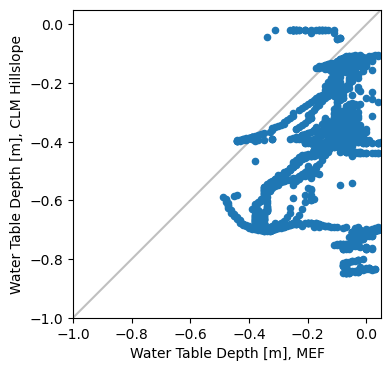

In [51]:
'''Plot model correlation'''
#Remove leap years
obsWTE = wte_all[~((wte_all['DATE'].dt.month == 2) &(wte_all['DATE'].dt.day == 29))].WTD
modWTE = Bog.ZWT[(Bog.time.dt.year < 2018) & (Bog.time.dt.year > 2011)]
#plot
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.axline([0, 0], [2, 2], color = 'silver')
ax.scatter(obsWTE, -modWTE, s = 20, zorder = 2)
ax.set_xlabel('Water Table Depth [m], MEF')
ax.set_ylabel('Water Table Depth [m], CLM Hillslope')
ax.set_xlim(-1, 0.05)
ax.set_ylim(-1, 0.05)
ax.set_aspect('equal', 'box')

In [37]:
rsquared(modWTE, obsWTE)

0.11965789658464447

In [38]:
nse(modWTE, obsWTE)

-28.372122352590093

In [39]:
spearman(modWTE, obsWTE)

-0.2899726903124978

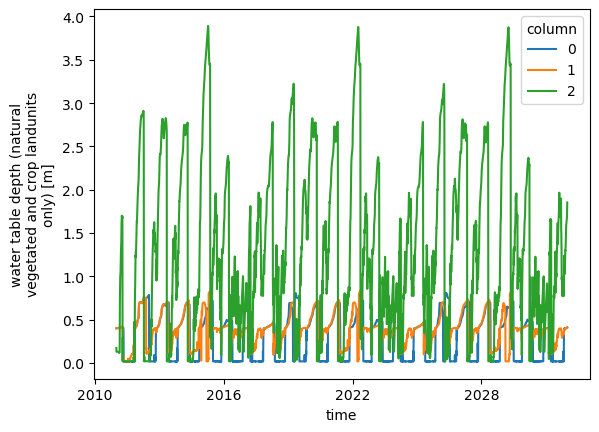

In [24]:
coldata.ZWT.plot.line(x = 'time') 